### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
# In this notebook, you will learn to call OCI Language from a Data Science Notebook, and how to do analysis on the data.
# More specifically, in this exercise you will ingest a set of hotel reviews, use OCI Language to identify the aspects sentiment in those reviews.
# You will not need to write any code from scratch, but we expect you to read the code and understand what we are doing. You can click Shift+Enter on each cell to run the code in the cell.

In [4]:
# Installing required libraries
!pip install pandas
!pip install ipymarkup
!pip install matplotlib
!pip install wordcloud

     |████████████████████████████████| 366 kB 23.3 MB/s eta 0:00:01


In [5]:
import oci
import pandas as pd
from ipymarkup import show_ascii_markup
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, GREEN, BLUE, RED
from matplotlib import pyplot as plt

# Read the data file

In [7]:
AllHotelData = pd.read_csv('Data.csv')

In [8]:
hotelNames = AllHotelData['name'].unique()
for hotel in hotelNames:
    print(hotel)

The Whitney Hotel
Best Western Seven Seas
Quality Suites San Diego SeaWorld Area
Hotel Abri


# Enter Hotel Name you want to analyze

In [10]:
#Enter Hotel Name you want to analyze
hotelName = "Best Western Seven Seas"

In [11]:
HotelData = AllHotelData[AllHotelData['name']==hotelName]
Data = HotelData[['Reviews','reviews.date']].reset_index()

In [12]:
# Create Language service client with user config default values.
ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())

## For every review call language sentiment and get the Aspect with their Polarity

In [13]:
#Detect Sentiment
data_with_result=[]
result=[]

for data in range(Data['Reviews'].size):
    try:
        detect_language_sentiments_details = oci.ai_language.models.DetectLanguageSentimentsDetails(text=Data['Reviews'][data])
        output = ai_client.detect_language_sentiments(detect_language_sentiments_details)
#         result[0] += [output.data]
#         result[1] += [Data['reviews.date'][data]]
        Dict = {'Result':output.data, 'Date':Data['reviews.date'][data]}
        result.append(Dict)
    except oci.exceptions.ServiceError as e:
        print("Something went wrong")
    

## View the sentence with detected aspect and their polarity

In [16]:
#View the sentences with the detected Named Entites.
# no_of_sentences = len(result)
no_of_sentences = 5
for sen in range(no_of_sentences):
    spans=[]
    for res in result[sen]['Result'].aspects:
        spans += [(res.offset, res.offset+res.length, res.sentiment)]
    show_box_markup(Data['Reviews'][sen], spans, palette=palette(Positvie=GREEN, Negative=RED, Neutral=BLUE))
    print()

In [17]:
# build out a data frame of all the aspects and their sentiments
no_of_sentences = len(result)
# no_of_sentences = 1
aspects=[]
for res in range(no_of_sentences):
    for i in result[res]['Result'].aspects:
        temp_aspects = (i.text, i.sentiment, i.scores, result[res]['Date'])
        aspects.append(temp_aspects)
aspects_frame = pd.DataFrame(aspects, 
                            columns=['Aspect', 'Sentiment', 'Score', 'Date'])

## Get the top-10 aspect w.r.t frequency of their occurance

In [19]:
# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
top_aspects = (aspects_frame.groupby(by=['Aspect'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

,Aspect,Frequency
0,staff,53
1,room,51
2,location,37
3,rooms,35
4,pool,26
5,hotel,25
6,breakfast,22
7,grounds,21
8,Western,19
9,place,16


## Plot the poarity graph for top aspect

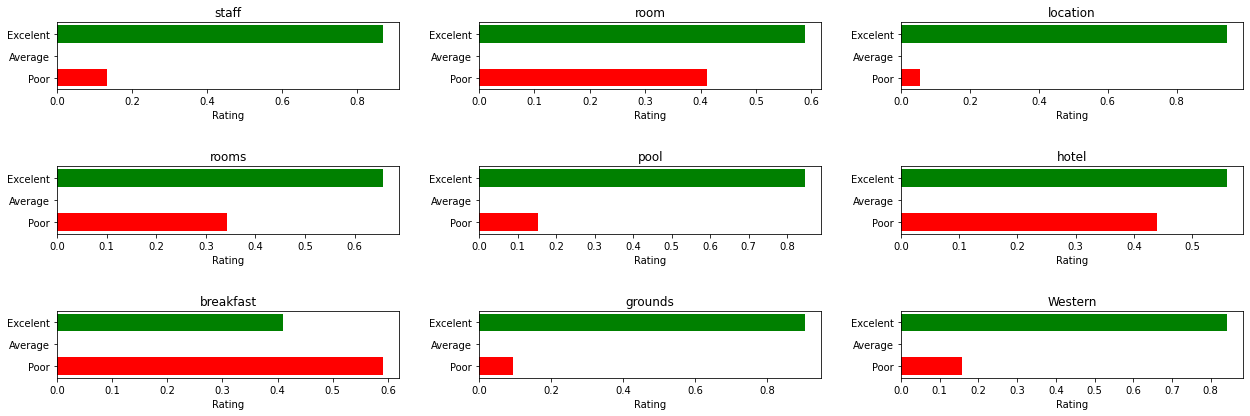

In [20]:
#Plotting the rating of top aspects detected.
plt.figure(figsize=(18,10))
all_top_aspects=[]
no_of_top_aspects=9
for i in range(no_of_top_aspects):
    asp = top_aspects.iloc[i]['Aspect']
    temp = aspects_frame[aspects_frame['Aspect']==top_aspects.iloc[i]['Aspect']]
    tot_count = temp.count().Aspect
    exce = temp[temp['Sentiment']=='Positive'].count().Aspect/tot_count
    poor = temp[temp['Sentiment']=='Negative'].count().Aspect/tot_count
    avrg = temp[temp['Sentiment']=='Neutral'].count().Aspect/tot_count
    plt.subplot(5, 3, i+1)
    y=['Poor', 'Average', 'Excelent']
    x=[poor,avrg,exce]
    plt.barh(y, x, color=['red', 'grey', 'green'])
    plt.xlabel("Rating") 
    plt.title(asp)
plt.tight_layout(pad=3.0)
plt.show()

In [21]:
## Get the top aspect with polarity

In [22]:
# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
top_aspects = (aspects_frame.groupby(by=['Aspect', 'Sentiment'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
0,staff,Positive,46
1,location,Positive,35
2,room,Positive,30
3,rooms,Positive,23
4,pool,Positive,22
5,room,Negative,21
6,grounds,Positive,19
7,Western,Positive,16
8,hotel,Positive,14
9,parking,Positive,14


## Get the top 5 aspect with positive polarity

In [23]:
#Top Positive Aspects
no_of_top_aspects=5
top_aspects_positive = top_aspects[top_aspects['Sentiment'] == 'Positive']
top_aspects_positive.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
0,staff,Positive,46
1,location,Positive,35
2,room,Positive,30
3,rooms,Positive,23
4,pool,Positive,22


## Get the top 5 aspect with negative polarity

In [24]:
#Top Negative Aspects
no_of_top_aspects=5
top_aspects_negative = top_aspects[top_aspects['Sentiment'] == 'Negative']
top_aspects_negative.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
5,room,Negative,21
10,breakfast,Negative,13
12,rooms,Negative,12
13,hotel,Negative,11
23,bed,Negative,7


## View the wordcloud with positive and negative aspect

In [25]:
content_pos=''
content_neg=''
for i in top_aspects_positive['Aspect'][0:len(top_aspects_positive['Aspect'])+1]:
    content_pos = content_pos + i + " "
for i in top_aspects_negative['Aspect'][0:len(top_aspects_negative['Aspect'])+1]:
    content_neg = content_neg + i + " "

In [26]:
colour_dict = {
    'green':140,
    'blue': 220,
    'red': 20
}
def red_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['red'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
def green_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['green'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

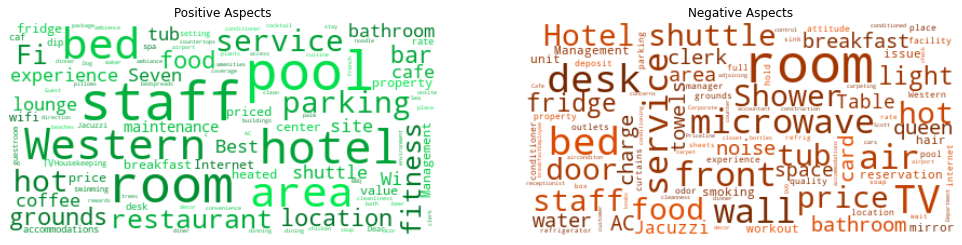

In [27]:
#Plotting Word Cloud
from wordcloud import WordCloud, STOPWORDS
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= green_fn).generate(content_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= red_fn).generate(content_neg)
plt.figure(figsize=(17,14))
# plt.figure()
plt.subplot(1, 2, 1)
plt.title("Positive Aspects")
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Negative Aspects")
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()